In [6]:
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
import requests
file_name = 'opencovid19-fr-chiffres-cles.csv'
url = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv'
myfile = requests.get(url)
open(file_name, 'wb').write(myfile.content)

1803165

In [7]:
data = pd.read_csv('opencovid19-fr-chiffres-cles.csv')

In [8]:
for a in data[["maille_code", "maille_nom"]].groupby(["maille_code", "maille_nom"]):
    print(f"{a[0]}")

('COM-974', 'La Réunion')
('COM-977', 'Saint-Barthélemy')
('COM-978', 'Saint-Martin')
('COM-986', 'Wallis et Futuna')
('COM-987', 'Polynésie française')
('COM-988', 'Nouvelle-Calédonie')
('DEP-01', 'Ain')
('DEP-02', 'Aisne')
('DEP-03', 'Allier')
('DEP-04', 'Alpes-de-Haute-Provence')
('DEP-05', 'Hautes-Alpes')
('DEP-06', 'Alpes-Maritimes')
('DEP-07', 'Ardèche')
('DEP-08', 'Ardennes')
('DEP-09', 'Ariège')
('DEP-10', 'Aube')
('DEP-11', 'Aude')
('DEP-12', 'Aveyron')
('DEP-13', 'Bouches-du-Rhône')
('DEP-14', 'Calvados')
('DEP-15', 'Cantal')
('DEP-16', 'Charente')
('DEP-17', 'Charente-Maritime')
('DEP-18', 'Cher')
('DEP-19', 'Corrèze')
('DEP-21', "Côte-d'Or")
('DEP-22', "Côtes-d'Armor")
('DEP-23', 'Creuse')
('DEP-24', 'Dordogne')
('DEP-25', 'Doubs')
('DEP-26', 'Drôme')
('DEP-27', 'Eure')
('DEP-28', 'Eure-et-Loir')
('DEP-29', 'Finistère')
('DEP-2A', 'Corse-du-Sud')
('DEP-2B', 'Haute-Corse')
('DEP-30', 'Gard')
('DEP-31', 'Haute-Garonne')
('DEP-32', 'Gers')
('DEP-33', 'Gironde')
('DEP-34', 'Hér

In [9]:
def enable_time_series_plot(
    in_df, 
    timein_field='time', 
    timeseries_field_out='date', 
    date_format="%Y-%m-%d",
    ):
    """
    Small tool to add a field to a dataframe which can be used for time series
    plotting
    """
    if timeseries_field_out not in in_df.columns:
        in_df[timeseries_field_out] = pd.to_datetime(
            in_df[timein_field],
            format=date_format
        )
    return in_df
data = enable_time_series_plot(data, timein_field='date', 
    timeseries_field_out='t')

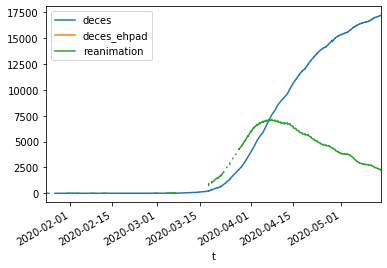

In [14]:
fra = fra[["t", "deces", "deces_ehpad", "reanimation"]]
fra.plot(x="t")

In [13]:
def axis_date_limits(ax, min_date=None, max_date=None):
    # Tailor axis limits
    x_min, x_max = pd.to_datetime(ax.get_xlim())
    if not (max_date is None):
        ax.set_xlim(right=min(x_max, pd.to_datetime(max_date)))
    if not (min_date is None):
        ax.set_xlim(left=max(x_min, pd.to_datetime(min_date)))

In [223]:
def func(data, maille_code, rows=["t", "deces", "deces_ehpad", "reanimation", "hospitalises"]):
    if maille_code == 'FRA':
        fra = data.loc[(data["maille_code"]==maille_code) & (data["source_nom"]!='OpenCOVID19-fr'),]
        
    else:
        fra = data.loc[(data["maille_code"]==maille_code) & (data["source_nom"]=='OpenCOVID19-fr'),]

    region = fra["maille_nom"].unique()[0]
    fra = fra[rows]
    non_time_rows = [key for key in rows if key != 't']
    # Fill nas
    for i, (ind, row)  in enumerate(fra.iterrows()):
        for f in non_time_rows:
            if pd.isna(row[f]):
                if i > 0:
                    fra.loc[ind, f] = fra.iloc[i-1,][f]
                else:
                    fra.loc[ind, f] = 0.0
    fra = fra.groupby(["t"]).aggregate(
        {
            "t":'first',
             **{key:'max' for key in non_time_rows}
        })
    fra = fra.set_index("t")
    # ajout des totaux par jours
    def par_jour(df): return df - [0, *(df[:-1])]
    fra["reanimation_cumul"] = fra["reanimation"].cumsum()
    non_time_rows.append("reanimation_cumul")
    fra["hospitalises_cumul"] = fra["hospitalises"].cumsum()
    non_time_rows.append("hospitalises_cumul")
    for f in non_time_rows:
        fra[f + "_jour"] = par_jour(fra[f])
        f += "_jour" 
        fra[f + "_jour"] = par_jour(fra[f])
    # Ajout de entree + sortie vivante de reanimation
    fra["reanimation_solde_vivant_jour"] = fra["reanimation_jour"] + fra["deces_jour"]
    fra["reanimation_solde_vivant_jour_jour"] = par_jour(fra["reanimation_solde_vivant_jour"])
    # Rolling averages
    for f in [*non_time_rows, "reanimation_solde_vivant"]:
        f = f + "_jour"
        fra[f + "_mma"] = fra[f].rolling(7).mean()
        f = f + "_jour"
        fra[f + "_mma"] = fra[f].rolling(7).mean()
    
    for f in ["deces_jour_mma", "deces_ehpad_jour_mma"]:
        fra[f + "_jour"] = fra[f] - [0, *(fra[f][:-1])]

    for f in non_time_rows:
        fra[f + "_jour_prop"] = fra[f + "_jour_mma"] / fra[f]
    f = "reanimation_solde_vivant"
    fra[f + "_jour_prop"] = fra[f + "_jour_mma"] / fra["reanimation"]
    f = "deces_jour_mma"
    fra[f + "_jour_prop"] = fra[f + "_jour"] / fra["deces_jour_mma"]

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches((15, 5))
    for i, ext in enumerate(["_jour", "_jour_mma", "_jour_prop"]):
       
        fra.plot(
            y=["deces" + ext, "deces_ehpad" + ext, "reanimation" + ext, "reanimation_solde_vivant" + ext],
            ax=axs[i]
        )
        
        axs[i].set_title(region)
        axis_date_limits(axs[i], min_date="2020-03-01")
    return fra

In [22]:
list_reg = [r for r in data["maille_code"].unique() if "REG" in r]

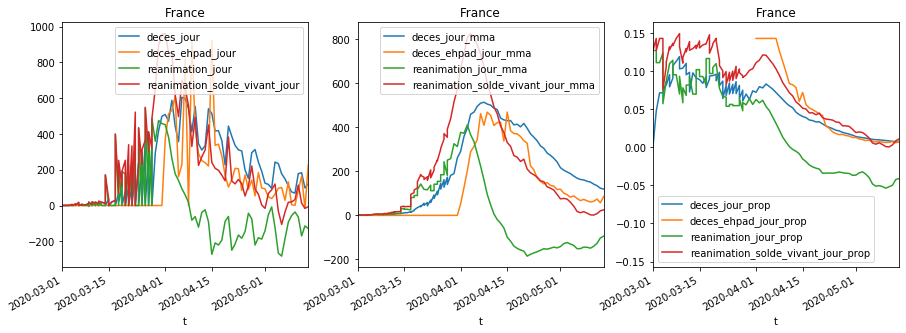

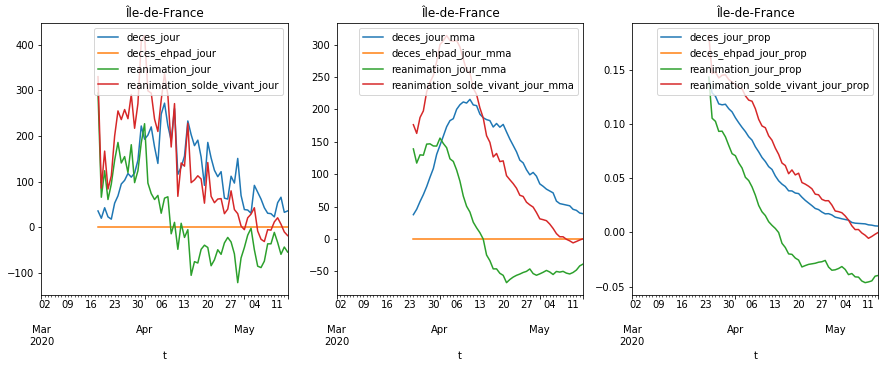

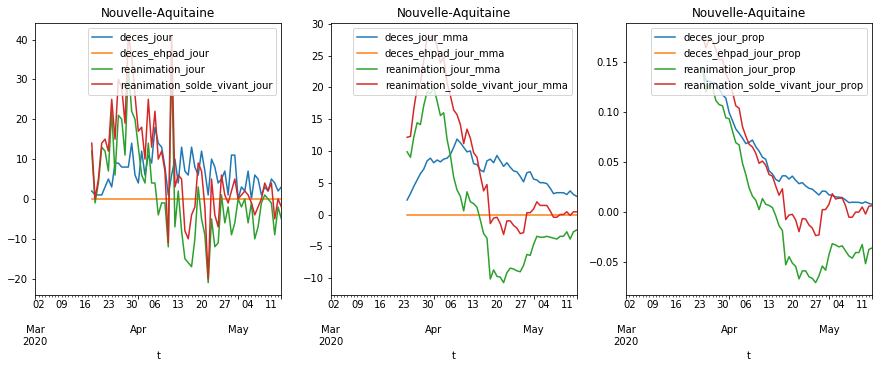

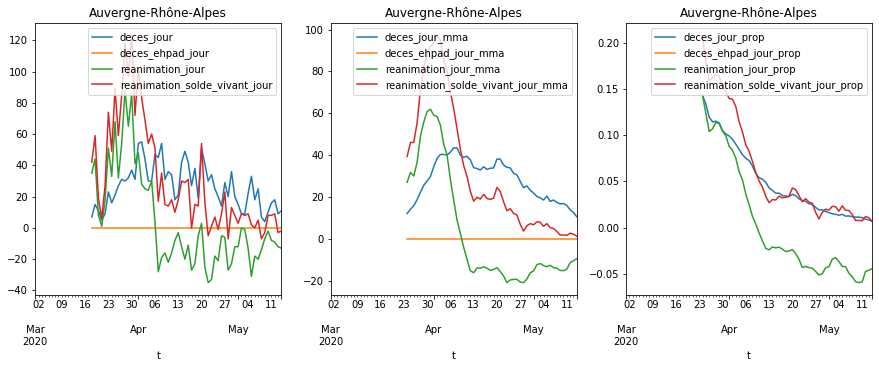

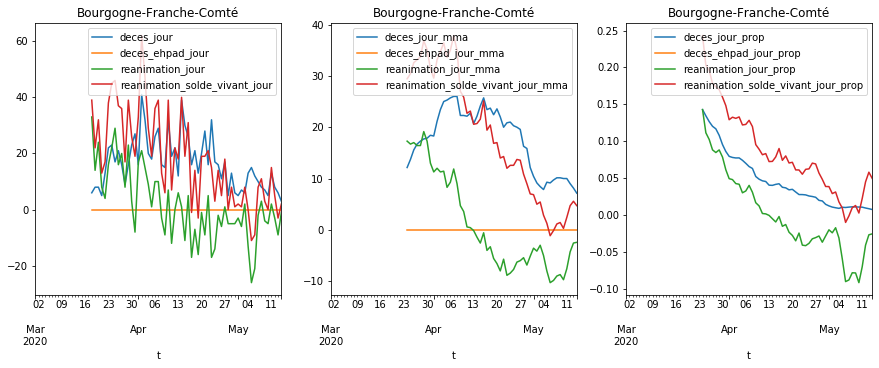

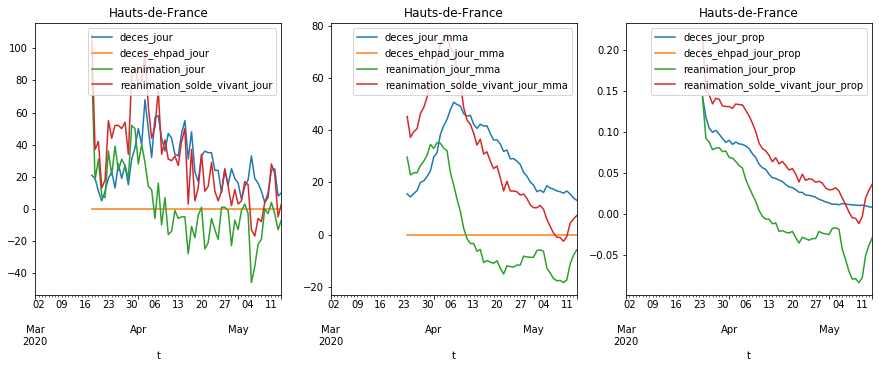

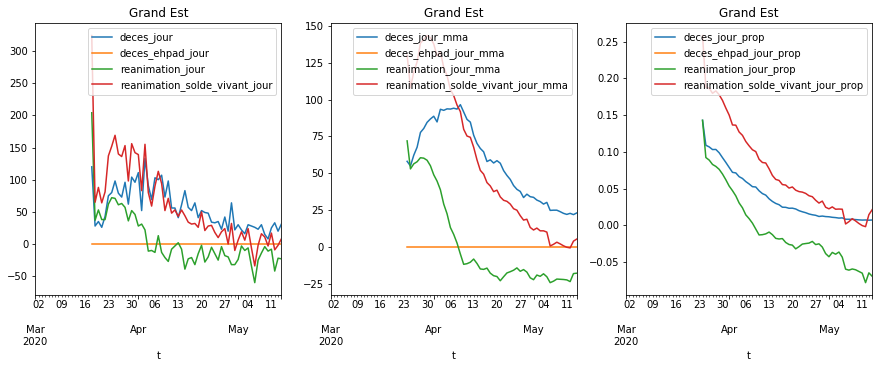

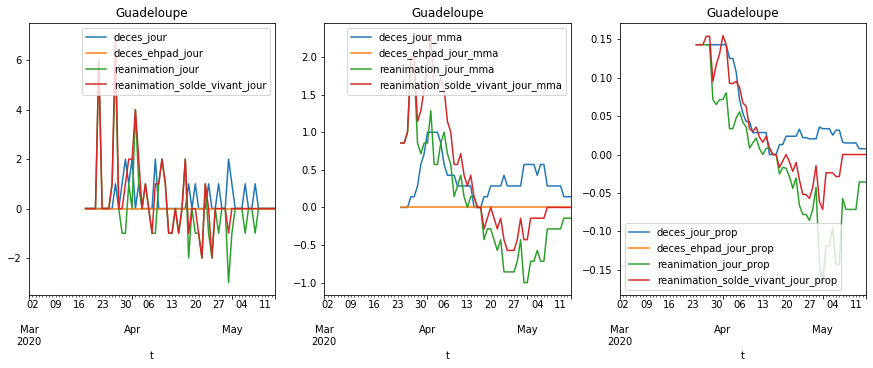

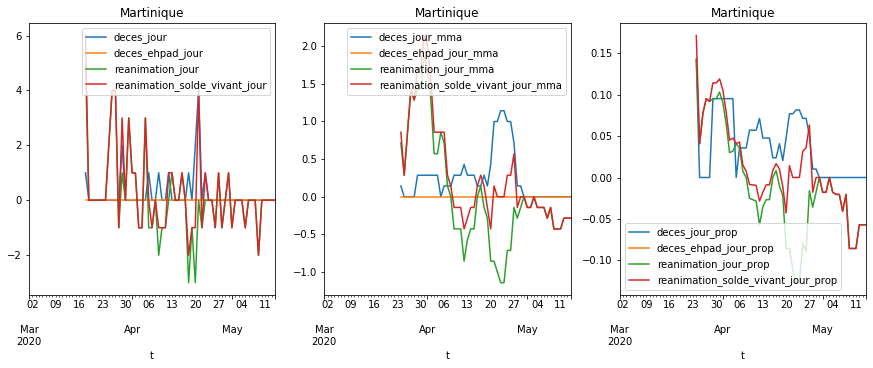

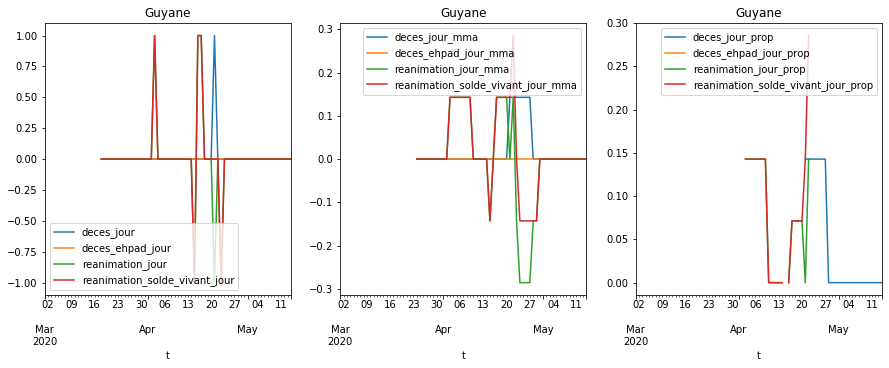

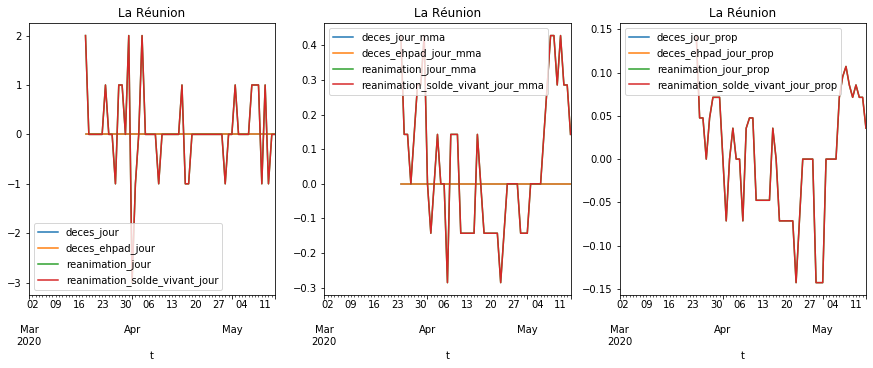

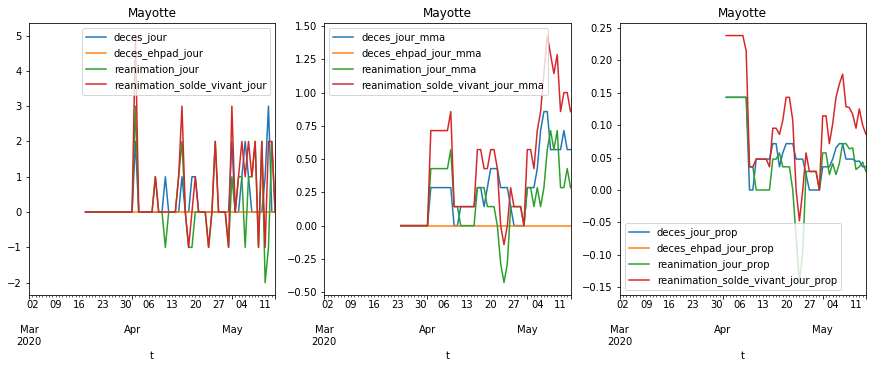

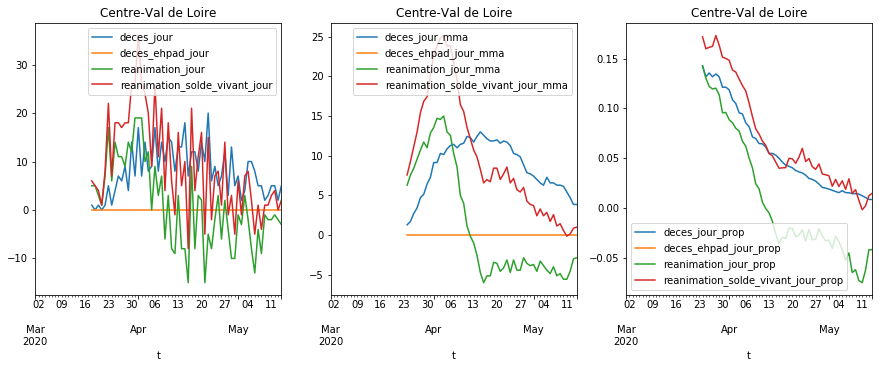

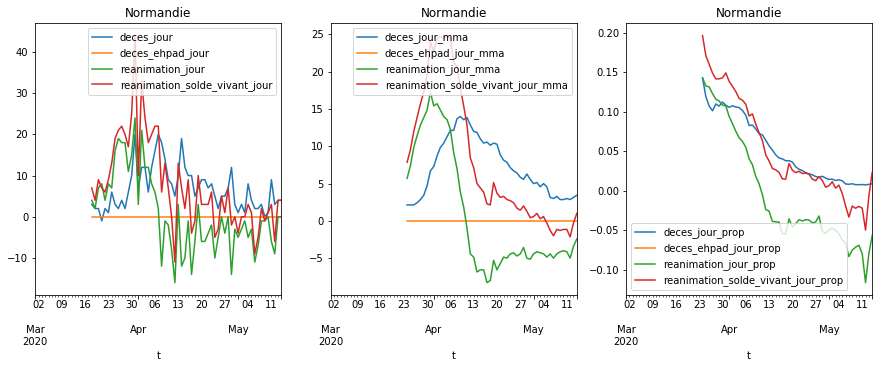

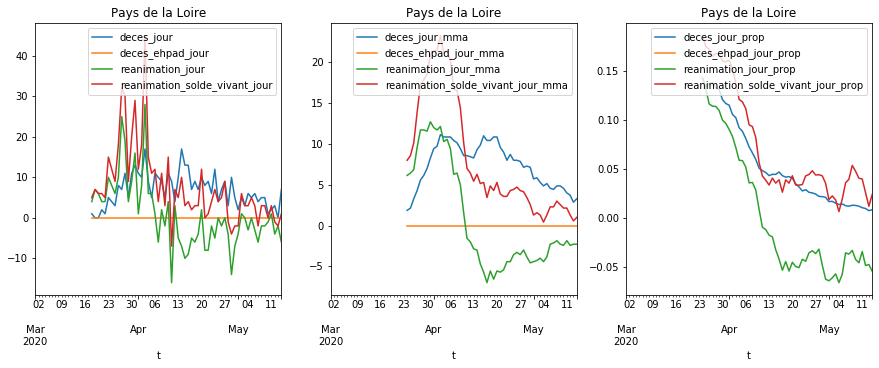

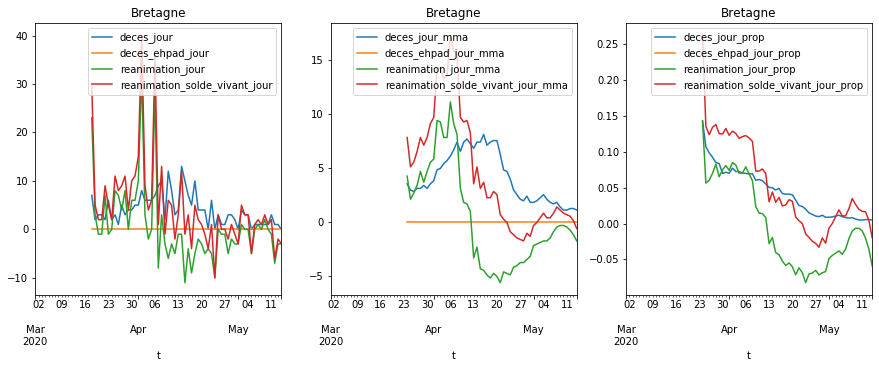

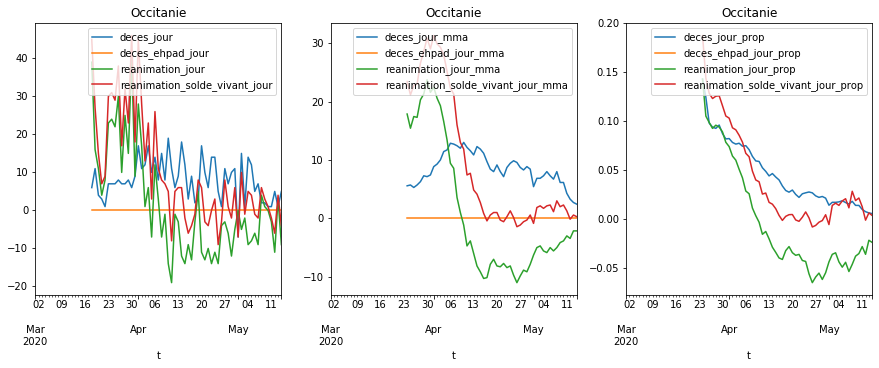

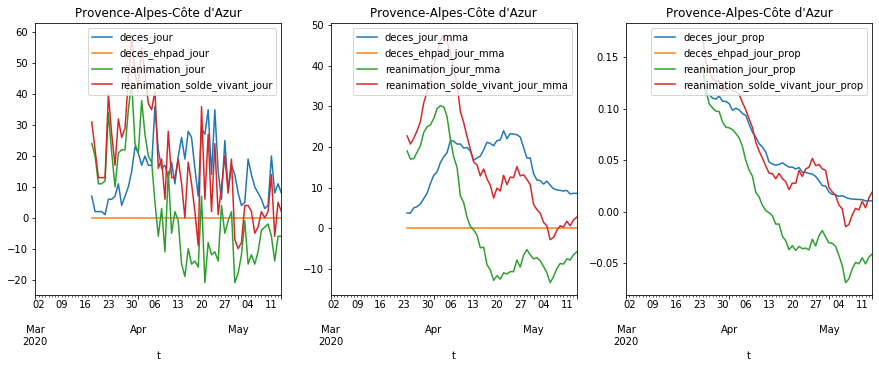

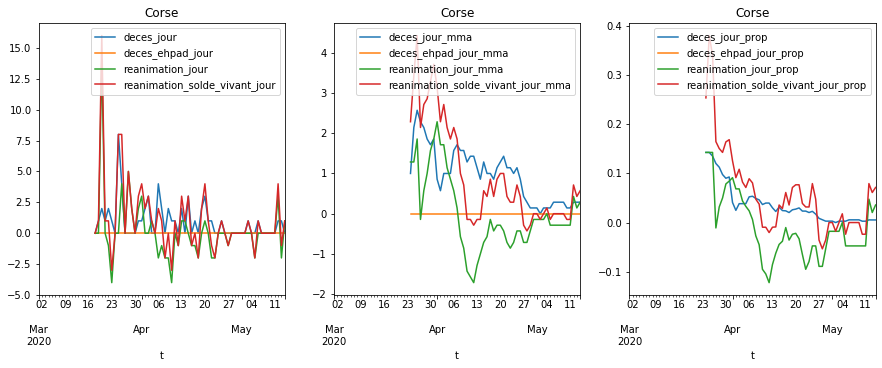

In [24]:
func(data, 'FRA')
for reg in list_reg:
    func(data, reg)

In [92]:
fra.tail()

t    deces  deces_ehpad  reanimation  deces_jour  \
8816 2020-05-03  15583.0       9312.0       3819.0        96.0   
8937 2020-05-04  15826.0       9375.0       3696.0       243.0   
9058 2020-05-05  16060.0       9471.0       3430.0       234.0   
9179 2020-05-06  16237.0       9572.0       3147.0       177.0   
9300 2020-05-07  16386.0       9601.0       2961.0       149.0   

      deces_ehpad_jour  reanimation_jour  deces_jour_mma  \
8816              39.0              -8.0      197.285714   
8937              63.0            -123.0      189.857143   
9058              96.0            -266.0      178.571429   
9179             101.0            -283.0      169.142857   
9300              29.0            -186.0      163.142857   

      deces_ehpad_jour_mma  reanimation_jour_mma  
8816             94.000000           -123.285714  
8937             82.714286           -130.285714  
9058             88.714286           -136.714286  
9179             76.857143           -151.428571  
9300             67.000000           -151.142857

In [268]:
from matplotlib.ticker import FuncFormatter
from matplotlib.rcsetup import cycler

def rol_val(df, list_rolls, **kwargs):
    if list_rolls:
        return rol_val(df,list_rolls[:-1],**kwargs).rolling(list_rolls[-1],**kwargs).mean()
    else:
        return df
def plot_field_loops(fra, field, smoothing = [7,2,3], **kwargs):
    smooth_rol_val = lambda df: rol_val(
        df,
        smoothing,
        **kwargs
    )

    fra[field + "_smooth_acceleration"] = smooth_rol_val(fra[field + "_jour_jour"])
    fra[field + "_jour_smooth"] =  smooth_rol_val(fra[field + "_jour"])

    fra[field + "_smooth_acceleration_prop"] = fra[field + "_smooth_acceleration"] / fra[field + "_jour_mma"]

    fig, axs = plt.subplots(1,3)
    fig.suptitle(f"Acceleration du nombre de {field} en {maille_active}")
    fig.set_size_inches(16,5)
    colors = []
    for c in plt.rcParams["axes.prop_cycle"].by_key()['color']:
        colors.append(c)
        colors.append(c)
    for ax in axs[:2]:
        ax.set_prop_cycle(cycler(color=colors))


    date_debut = pd.date_range(start='2020-03-09', periods=1, freq='d')
    date_fin = pd.to_datetime('2020-05-10')
    rolling_val = [1]

    rolled_fra = rol_val(fra, rolling_val)
    while date_debut < date_fin:
        week_label = f'semaine du {date_debut[0].strftime("%d/%m")}'
        ind_log =  (date_debut[0] <= rolled_fra.index) & (rolled_fra.index <= date_debut[0]+7)
        # Timeline
        rolled_fra[ind_log].plot(
            y=field + "_jour", marker='o', linestyle='',
            ax=axs[0], label='', markersize=3,
        )
        rolled_fra[ind_log].plot(
            y=field + "_jour_smooth", 
            ax=axs[0], label=week_label
        )
        # Timeline
        rolled_fra[ind_log].plot(
            x=field + "_jour_smooth", y=field + "_jour_jour", 
            marker='o', ax=axs[1], label='', markersize=3, linestyle=''
        )
        rolled_fra[ind_log].plot(
            x=field + "_jour_smooth", y=field + "_smooth_acceleration", 
            marker='+', ax=axs[1], label=week_label
        )
        # Timeline
        rolled_fra[ind_log].plot(
            x=field + "_jour_smooth", y=field + "_smooth_acceleration_prop",
            marker='+', ax=axs[2], label=week_label
        )
        date_debut += 7
    for ax in axs:
        lines = []
        for line in ax.get_legend().get_lines():
            if line.get_label():
                lines.append(line)
        ax.legend(handles=lines)
    first_smooth = smoothing[:1]
    axs[0].set_ylabel(f"{field} par jour (moyenne sur {first_smooth} jours)")
    axs[0].grid('on')
    lines = []
    
    axs[1].set_xlabel("{} par jour (moyenne sur {} jours)".format(field, first_smooth))
    axs[1].set_ylabel("Delta journalier de l'abscisse ($x_t - x_{t-1}$)")
    axs[1].grid('on')

    axs[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    axs[2].grid('on')
    axs[2].set_ylabel("Delta proportionel journalier de l'abscisse")
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()

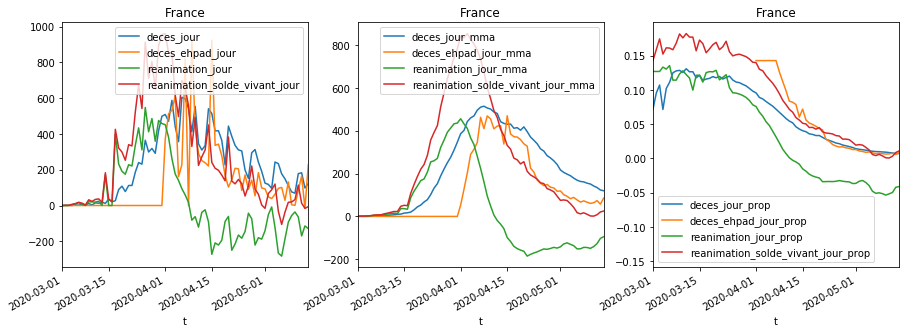

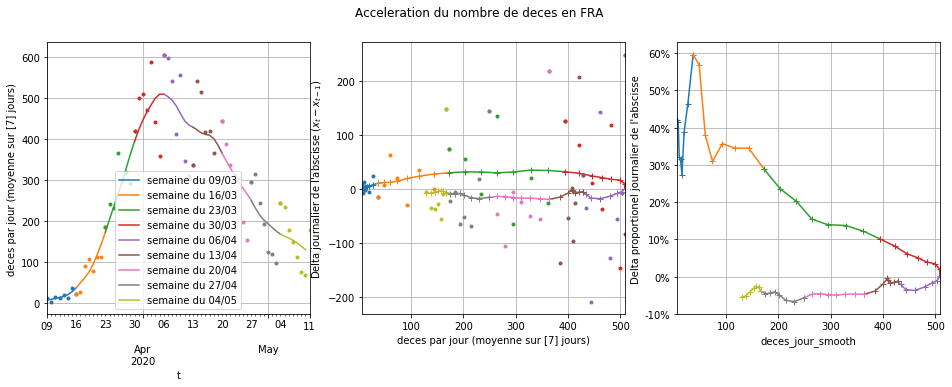

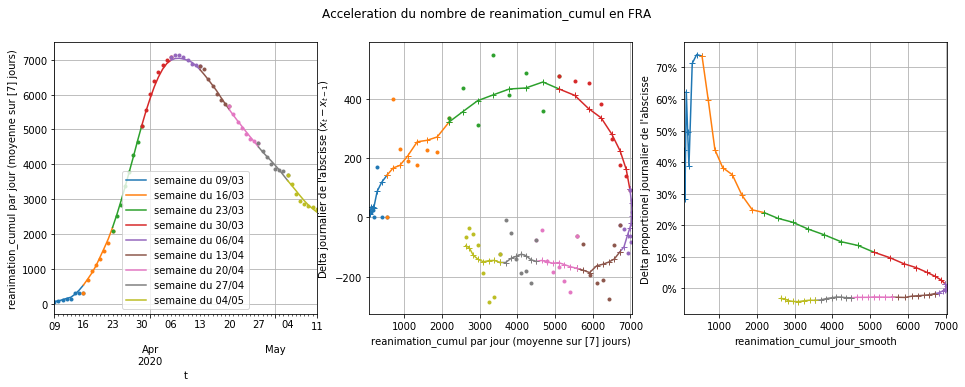

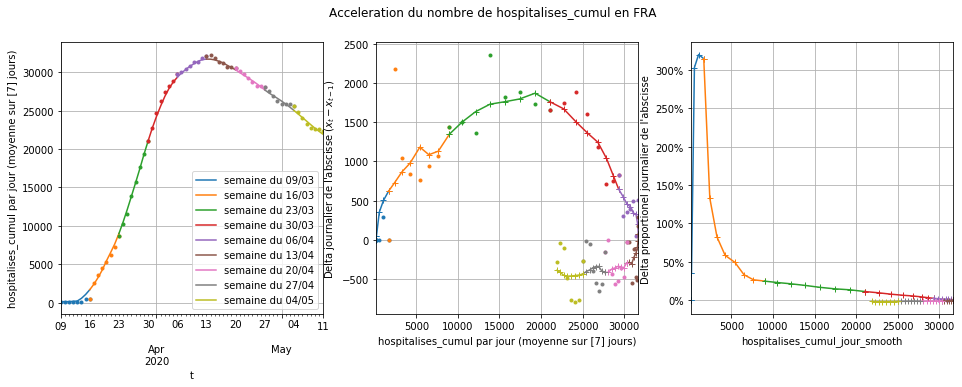

In [270]:
maille_active = 'FRA'
fra = func(data, maille_active)
plot_field_loops(fra, "deces", center=True)
plot_field_loops(fra, "reanimation_cumul", [7], center=True)
plot_field_loops(fra, "hospitalises_cumul", [7], center=True)

In [210]:
fra.sample()

deces  deces_ehpad  reanimation  hospitalises  reanimation_cumul  \
t                                                                              
2020-02-29    2.0          0.0          9.0          86.0               41.0   

            deces_jour  deces_jour_jour  deces_ehpad_jour  \
t                                                           
2020-02-29         0.0              0.0               0.0   

            deces_ehpad_jour_jour  reanimation_jour  ...  \
t                                                    ...   
2020-02-29                    0.0               7.0  ...   

            deces_jour_mma_jour_prop  deces_smooth_acceleration  \
t                                                                 
2020-02-29                       0.0                    0.02381   

            deces_jour_smooth  deces_smooth_acceleration_prop  \
t                                                               
2020-02-29           0.142857                        0.166667   

            reanimation_cumul_smooth_acceleration  \
t                                                   
2020-02-29                               0.285714   

            reanimation_cumul_jour_smooth  \
t                                           
2020-02-29                       1.380952   

            reanimation_cumul_smooth_acceleration_prop  \
t                                                        
2020-02-29                                    0.117647   

            hospitalises_smooth_acceleration  hospitalises_jour_smooth  \
t                                                                        
2020-02-29                               NaN                       NaN   

            hospitalises_smooth_acceleration_prop  
t                                                  
2020-02-29                                    NaN  

[1 rows x 47 columns]